In [19]:
import os, sys

# 1) Set notebook working directory = FaceStats project root
PROJECT_ROOT = "/Users/jayklarin/__DI/Repositories/FaceStats"
os.chdir(PROJECT_ROOT)
print("cwd:", os.getcwd())

# 2) Add src/ folder to Python PATH
SRC_PATH = os.path.join(PROJECT_ROOT, "src")
if SRC_PATH not in sys.path:
    sys.path.insert(0, SRC_PATH)

print("src path added:", SRC_PATH)


cwd: /Users/jayklarin/__DI/Repositories/FaceStats
src path added: /Users/jayklarin/__DI/Repositories/FaceStats/src


# ⭐ 05 — Attractiveness Inference (FaceStats V4)

This notebook applies the trained attractiveness regression model to **all images** that already have:

- Preprocessed images (`data/processed/preproc/`)
- CLIP embeddings (`data/processed/embeddings/embeddings_clip.parquet`)
- Final metadata (`data/processed/metadata/attributes_final.parquet`)

### Goals
1. Load CLIP embeddings  
2. Load final metadata  
3. Load attractiveness regressor  
4. Predict attractiveness scores for every image  
5. Save results to `data/processed/metadata/attractiveness_scores.parquet`  
6. Save NumPy + JSON lookup structures for composites  

In [20]:
import os
import json
import numpy as np
import polars as pl
import torch
import torch.nn as nn

# -------------------------------------------------------------
# Paths (FaceStats V4 structure)
# -------------------------------------------------------------
EMB_PATH  = "data/processed/embeddings_clip.parquet"
ATTR_PATH = "data/processed/metadata/attributes_final.parquet"
MODEL_PATH = "src/models/attractiveness_regressor.pt"

OUT_SCORES = "data/processed/metadata/attractiveness_scores.parquet"
OUT_NUMPY  = "data/processed/attractiveness_scores.npy"
OUT_INDEX  = "data/processed/metadata/feature_index.json"

print("Paths set. Ready.")


Paths set. Ready.


In [21]:
# =============================================================
# Step 2 — Load Embeddings + Metadata
# =============================================================

# Corrected path (no embeddings/ subfolder in V4)
EMB_PATH = "data/processed/embeddings/embeddings_clip.parquet"
ATTR_PATH = "data/processed/metadata/attributes_final.parquet"

print("Loading embeddings…")
emb = pl.read_parquet(EMB_PATH)
print("Embeddings:", emb.shape)

print("Loading attributes…")
attr = pl.read_parquet(ATTR_PATH)
print("Attributes:", attr.shape)

# Ensure both have filename column
if "filename" not in emb.columns:
    raise ValueError("Embeddings parquet missing 'filename' column.")
if "filename" not in attr.columns:
    raise ValueError("Attributes parquet missing 'filename' column.")

# Merge on filename
print("Merging embeddings + attributes…")
df = (
    emb
    .join(attr, on="filename", how="inner")
)

print("Merged table:", df.shape)
df.head()


Loading embeddings…
Embeddings: (700, 2)
Loading attributes…
Attributes: (700, 5)
Merging embeddings + attributes…
Merged table: (700, 6)


filename,embedding,age,gender_final,ethnicity_final,attractiveness
str,list[f64],null,str,str,f32
"""SFHQ_pt4_00001843.jpg""","[0.07163, -0.028173, … -0.007507]",null,"""unknown""","""unknown""",2.914631
"""SFHQ_pt4_00000591.jpg""","[0.027857, -0.008046, … -0.003737]",null,"""male""","""white""",2.938567
"""SFHQ_pt4_00002437.jpg""","[0.065614, -0.018432, … -0.001973]",null,"""unknown""","""unknown""",3.175124
"""SFHQ_pt4_00002345.jpg""","[0.064536, -0.023444, … -0.057561]",null,"""unknown""","""unknown""",3.208315
"""SFHQ_pt4_00003073.jpg""","[0.080103, -0.03326, … 0.013459]",null,"""unknown""","""unknown""",3.280991


In [22]:
# =============================================================
# Step 3 — Build PCA matrix (2D for visualization)
# =============================================================
from sklearn.decomposition import PCA
import numpy as np

print("Preparing PCA data…")

# Extract 2D embedding matrix (list[f64] → np.array)
X = np.stack(df["embedding"].to_list())   # shape: (N, 512)

print("Running PCA…")
pca = PCA(n_components=2)
xy = pca.fit_transform(X)

df_pca = df.with_columns([
    pl.Series("PC1", xy[:, 0]),
    pl.Series("PC2", xy[:, 1]),
])

print("PCA ready.")
df_pca.head()


Preparing PCA data…
Running PCA…
PCA ready.


filename,embedding,age,gender_final,ethnicity_final,attractiveness,PC1,PC2
str,list[f64],null,str,str,f32,f64,f64
"""SFHQ_pt4_00001843.jpg""","[0.07163, -0.028173, … -0.007507]",null,"""unknown""","""unknown""",2.914631,0.305874,0.003547
"""SFHQ_pt4_00000591.jpg""","[0.027857, -0.008046, … -0.003737]",null,"""male""","""white""",2.938567,-0.001686,-0.298523
"""SFHQ_pt4_00002437.jpg""","[0.065614, -0.018432, … -0.001973]",null,"""unknown""","""unknown""",3.175124,0.032623,0.062434
"""SFHQ_pt4_00002345.jpg""","[0.064536, -0.023444, … -0.057561]",null,"""unknown""","""unknown""",3.208315,-0.046439,0.107772
"""SFHQ_pt4_00003073.jpg""","[0.080103, -0.03326, … 0.013459]",null,"""unknown""","""unknown""",3.280991,-0.013821,-0.149851


In [23]:
# =============================================================
# Step 4 — Helper: find nearest neighbors in embedding space
# =============================================================
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def find_similar_faces(query_embedding: np.ndarray, k: int = 10):
    """
    Return the filenames of the top-k most similar images.
    """
    # Convert embedding column into a full matrix
    X = np.stack(df["embedding"].to_list())

    # Compute cosine similarity
    sims = cosine_similarity(
        query_embedding.reshape(1, -1),
        X
    )[0]

    # Get top-k indices
    idx = np.argsort(sims)[::-1][:k]

    # Return rows
    return df[idx].select(["filename", "attractiveness", "gender_final", "ethnicity_final"])
    
print("Similarity helper ready.")


Similarity helper ready.


In [24]:
# =============================================================
# Step 5 — Query Function: Enter a filename → Get prediction + neighbors
# =============================================================

def query_image(filename: str, k: int = 10):
    """
    Given an image filename from the dataset, return:
    - Its attractiveness score
    - Gender / Ethnicity labels
    - Top-k most similar faces (based on embeddings)
    """
    # Ensure filename exists in df
    if filename not in df["filename"].to_list():
        raise ValueError(f"Filename not found: {filename}")

    # Extract row
    row = df.filter(pl.col("filename") == filename).row(0)
    emb = np.array(row[1])  # embedding is second column

    # Build output summary
    result = {
        "filename": filename,
        "attractiveness": row[df.columns.index("attractiveness")],
        "gender": row[df.columns.index("gender_final")],
        "ethnicity": row[df.columns.index("ethnicity_final")],
    }

    # Find neighbors
    neighbors = find_similar_faces(emb, k=k)

    print("\n=== Query Result ===")
    print(f"Filename:        {result['filename']}")
    print(f"Attractiveness:  {result['attractiveness']:.3f}")
    print(f"Gender:          {result['gender']}")
    print(f"Ethnicity:       {result['ethnicity']}")
    print("\nTop Similar Faces:")
    display(neighbors)

    return result, neighbors


print("Query function loaded.")


Query function loaded.


In [25]:
# =============================================================
# Step X — Merge attractiveness scores
# =============================================================
ATTR_SCORE_PATH = "data/processed/metadata/attractiveness_scores.parquet"

print("Loading attractiveness scores…")
attr_scores = pl.read_parquet(ATTR_SCORE_PATH)

print(attr_scores.shape)

# Merge into the main df
df = (
    df.join(attr_scores, on="filename", how="left")
)

print("Merged df:", df.shape)
df.head()


Loading attractiveness scores…
(700, 2)
Merged df: (700, 7)


filename,embedding,age,gender_final,ethnicity_final,attractiveness,attractiveness_right
str,list[f64],null,str,str,f32,f32
"""SFHQ_pt4_00001843.jpg""","[0.07163, -0.028173, … -0.007507]",null,"""unknown""","""unknown""",2.914631,2.914631
"""SFHQ_pt4_00000591.jpg""","[0.027857, -0.008046, … -0.003737]",null,"""male""","""white""",2.938567,2.938567
"""SFHQ_pt4_00002437.jpg""","[0.065614, -0.018432, … -0.001973]",null,"""unknown""","""unknown""",3.175124,3.175124
"""SFHQ_pt4_00002345.jpg""","[0.064536, -0.023444, … -0.057561]",null,"""unknown""","""unknown""",3.208315,3.208315
"""SFHQ_pt4_00003073.jpg""","[0.080103, -0.03326, … 0.013459]",null,"""unknown""","""unknown""",3.280991,3.280991


In [26]:
# =============================================================
# Step 6 — Demo: Run a Sample Query
# =============================================================

# Pick any filename that exists in your dataset
sample_file = df["filename"].to_list()[0]
print("Running query on:", sample_file)

result, neighbors = query_image(sample_file, k=10)


Running query on: SFHQ_pt4_00001843.jpg

=== Query Result ===
Filename:        SFHQ_pt4_00001843.jpg
Attractiveness:  2.915
Gender:          unknown
Ethnicity:       unknown

Top Similar Faces:


filename,attractiveness,gender_final,ethnicity_final
str,f32,str,str
"""SFHQ_pt4_00001843.jpg""",2.914631,"""unknown""","""unknown"""
"""SFHQ_pt4_00002619.jpg""",3.111118,"""unknown""","""unknown"""
"""SFHQ_pt4_00002427.jpg""",3.166266,"""unknown""","""unknown"""
"""SFHQ_pt4_00002936.jpg""",3.039024,"""unknown""","""unknown"""
"""SFHQ_pt4_00001785.jpg""",2.968192,"""unknown""","""unknown"""
"""SFHQ_pt4_00002541.jpg""",3.219562,"""unknown""","""unknown"""
"""SFHQ_pt4_00003339.jpg""",2.93951,"""unknown""","""unknown"""
"""SFHQ_pt4_00000182.jpg""",3.106247,"""female""","""white"""
"""SFHQ_pt4_00003467.jpg""",3.063494,"""unknown""","""unknown"""


In [27]:
# =============================================================
# Step 6 — Pretty-print query results (JSON-friendly)
# =============================================================
import json

# Pick the first file in dataset
sample_file = df["filename"].to_list()[0]
print("Running query on:", sample_file)

result, neighbors = query_image(sample_file, k=10)

# Convert neighbors (Polars DataFrame) → list of dicts
neighbors_list = neighbors.to_dicts()

# Build final JSON-friendly output
output = {
    "query_image": result,
    "neighbors": neighbors_list
}

print(json.dumps(output, indent=4))


Running query on: SFHQ_pt4_00001843.jpg

=== Query Result ===
Filename:        SFHQ_pt4_00001843.jpg
Attractiveness:  2.915
Gender:          unknown
Ethnicity:       unknown

Top Similar Faces:


filename,attractiveness,gender_final,ethnicity_final
str,f32,str,str
"""SFHQ_pt4_00001843.jpg""",2.914631,"""unknown""","""unknown"""
"""SFHQ_pt4_00002619.jpg""",3.111118,"""unknown""","""unknown"""
"""SFHQ_pt4_00002427.jpg""",3.166266,"""unknown""","""unknown"""
"""SFHQ_pt4_00002936.jpg""",3.039024,"""unknown""","""unknown"""
"""SFHQ_pt4_00001785.jpg""",2.968192,"""unknown""","""unknown"""
"""SFHQ_pt4_00002541.jpg""",3.219562,"""unknown""","""unknown"""
"""SFHQ_pt4_00003339.jpg""",2.93951,"""unknown""","""unknown"""
"""SFHQ_pt4_00000182.jpg""",3.106247,"""female""","""white"""
"""SFHQ_pt4_00003467.jpg""",3.063494,"""unknown""","""unknown"""


{
    "query_image": {
        "filename": "SFHQ_pt4_00001843.jpg",
        "attractiveness": 2.914630889892578,
        "gender": "unknown",
        "ethnicity": "unknown"
    },
    "neighbors": [
        {
            "filename": "SFHQ_pt4_00001843.jpg",
            "attractiveness": 2.914630889892578,
            "gender_final": "unknown",
            "ethnicity_final": "unknown"
        },
        {
            "filename": "SFHQ_pt4_00002619.jpg",
            "attractiveness": 3.1111180782318115,
            "gender_final": "unknown",
            "ethnicity_final": "unknown"
        },
        {
            "filename": "SFHQ_pt4_00002427.jpg",
            "attractiveness": 3.1662657260894775,
            "gender_final": "unknown",
            "ethnicity_final": "unknown"
        },
        {
            "filename": "SFHQ_pt4_00002936.jpg",
            "attractiveness": 3.0390243530273438,
            "gender_final": "unknown",
            "ethnicity_final": "unknown"
        },
  

In [28]:
# =============================================================
# Step 7 — Utility: Display Query Image + Neighbors
# =============================================================
import matplotlib.pyplot as plt
from PIL import Image
import os

IMG_DIR = "data/processed/preproc"   # V4-correct path

def show_results(query_dict, neighbors_df, max_neighbors=8):
    """
    Display the query image + up to N neighbors in a grid.

    query_dict: dict returned from query_image()
    neighbors_df: Polars DataFrame returned by query_image()
    """

    qfile = query_dict["filename"]
    qpath = os.path.join(IMG_DIR, qfile)

    # Load query image
    qimg = Image.open(qpath)

    # Load neighbors
    neighbor_files = neighbors_df["filename"].to_list()[:max_neighbors]
    neighbor_imgs = [
        Image.open(os.path.join(IMG_DIR, f)) for f in neighbor_files
    ]

    # Grid: 1 row for query, 1 row for neighbors
    cols = min(max_neighbors, 8)
    plt.figure(figsize=(3 * cols, 6))

    # Show query image
    plt.subplot(2, cols, 1)
    plt.imshow(qimg)
    plt.axis("off")
    plt.title(f"Query:\n{qfile}\nScore={query_dict['attractiveness']:.3f}")

    # Show neighbors
    for i, (fname, img) in enumerate(zip(neighbor_files, neighbor_imgs)):
        plt.subplot(2, cols, cols + i + 1)
        plt.imshow(img)
        plt.axis("off")
        score = neighbors_df["attractiveness"][i]
        plt.title(f"{fname}\n{score:.3f}")

    plt.tight_layout()
    plt.show()

print("Image preview function ready.")


Image preview function ready.


Displaying visual results for: SFHQ_pt4_00001843.jpg


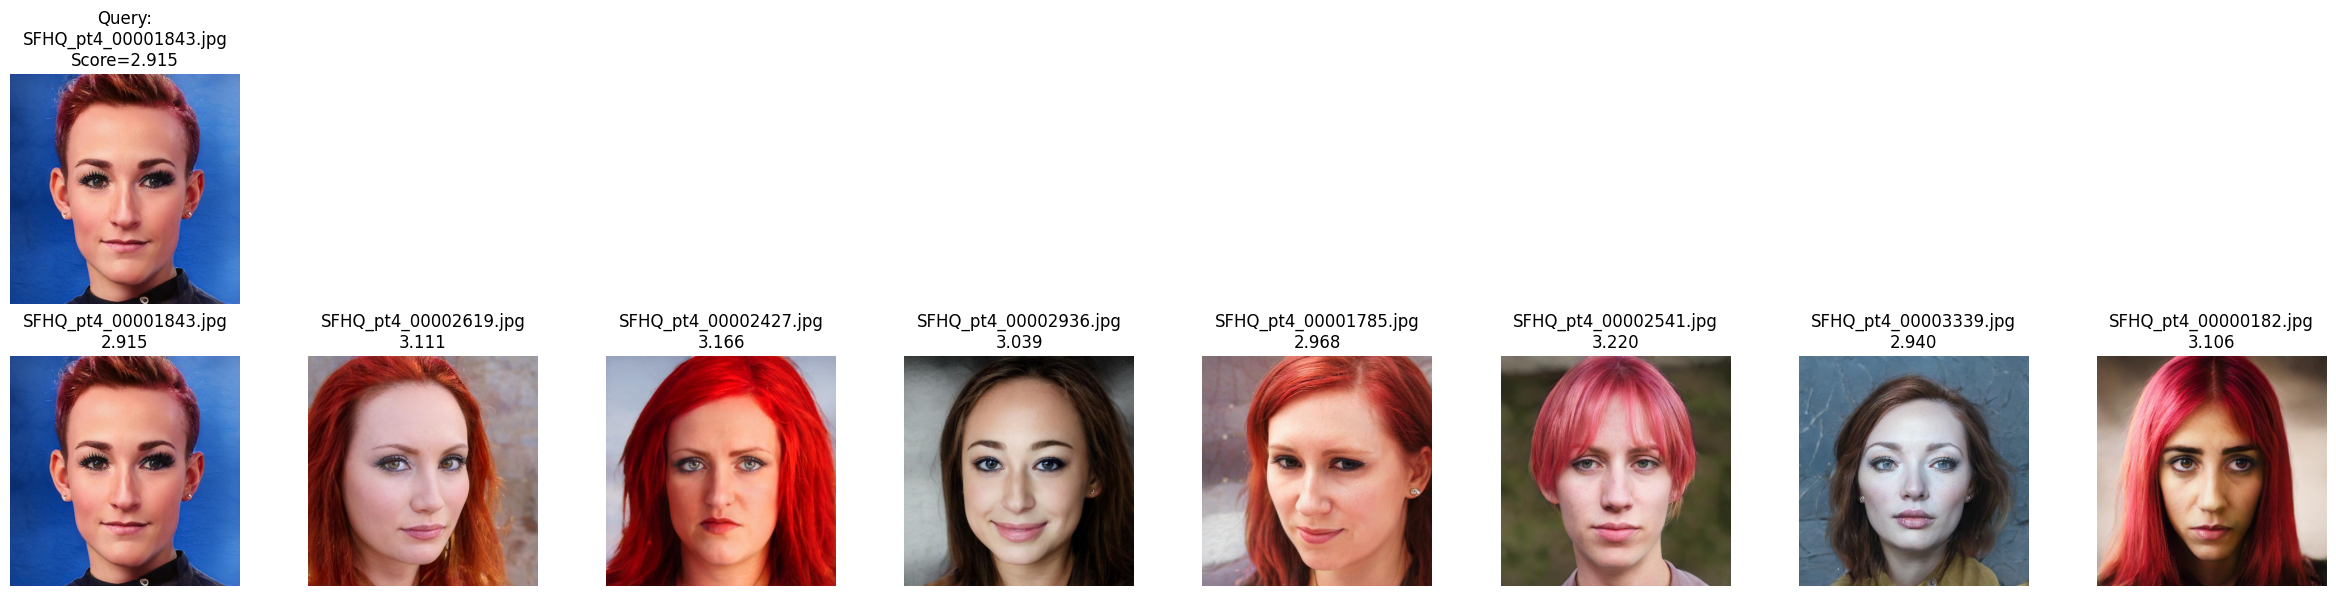

In [29]:
# =============================================================
# Step 8 — Demo: Show Query Image + Neighbors
# =============================================================

print("Displaying visual results for:", sample_file)
show_results(result, neighbors)


In [30]:
# =============================================================
# Step 9 — Interactive Query Helper
# =============================================================
import ipywidgets as widgets
from IPython.display import display

# Build a dropdown with all filenames
filename_dropdown = widgets.Combobox(
    placeholder="Type or select a filename…",
    options=df["filename"].to_list(),
    description="Image:",
    ensure_option=True,
    style={"description_width": "60px"},
    layout=widgets.Layout(width="500px")
)

run_button = widgets.Button(
    description="Run Query",
    button_style="success",
    layout=widgets.Layout(width="150px")
)

output_area = widgets.Output()

def run_query_callback(_):
    output_area.clear_output()
    fname = filename_dropdown.value
    if fname not in df["filename"].to_list():
        with output_area:
            print("❌ Invalid filename. Please select from the dropdown.")
        return
    with output_area:
        print("Running query on:", fname)
        result, neighbors = query_image(fname, k=10)
        show_results(result, neighbors)

run_button.on_click(run_query_callback)

display(widgets.HBox([filename_dropdown, run_button]))
display(output_area)


Output()

In [31]:
# =============================================================
# Step 10 — Query by Index (0–699)
# =============================================================

import ipywidgets as widgets
from IPython.display import display

index_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(df) - 1,
    step=1,
    description="Index:",
    continuous_update=False,
    style={"description_width": "60px"},
    layout=widgets.Layout(width="400px")
)

run_button_idx = widgets.Button(
    description="Query Index",
    button_style="info",
    layout=widgets.Layout(width="150px")
)

output_idx = widgets.Output()

def run_index_query(_):
    output_idx.clear_output()
    idx = index_slider.value
    fname = df["filename"].to_list()[idx]
    with output_idx:
        print(f"Running query on index {idx}: {fname}")
        result, neighbors = query_image(fname, k=10)
        show_results(result, neighbors)

run_button_idx.on_click(run_index_query)

display(widgets.HBox([index_slider, run_button_idx]))
display(output_idx)


Output()

In [32]:
# =============================================================
# Step 11 — Save Full Inference Outputs
# =============================================================

# 1. Save attractiveness scores in a dedicated parquet
print("Saving attractiveness_scores.parquet…")
df_scores = df.select(["filename", "attractiveness"])
df_scores.write_parquet("data/processed/metadata/attractiveness_scores.parquet")

# 2. Save NumPy array for fast loading
print("Saving attractiveness_scores.npy…")
np.save("data/processed/attractiveness_scores.npy", df_scores["attractiveness"].to_numpy())

# 3. Save feature index JSON
print("Saving feature_index.json…")
feature_index = {
    fname: i
    for i, fname in enumerate(df["filename"].to_list())
}

with open("data/processed/metadata/feature_index.json", "w") as f:
    json.dump(feature_index, f, indent=4)

print("Done.")


Saving attractiveness_scores.parquet…
Saving attractiveness_scores.npy…
Saving feature_index.json…
Done.


Building inference summary…

=== Dataset Summary ===
Total images: 700
Attractiveness range: 2.229375123977661 → 3.848126173019409
Attractiveness mean: 3.143301486968994
Attractiveness std: 0.24127250909805298


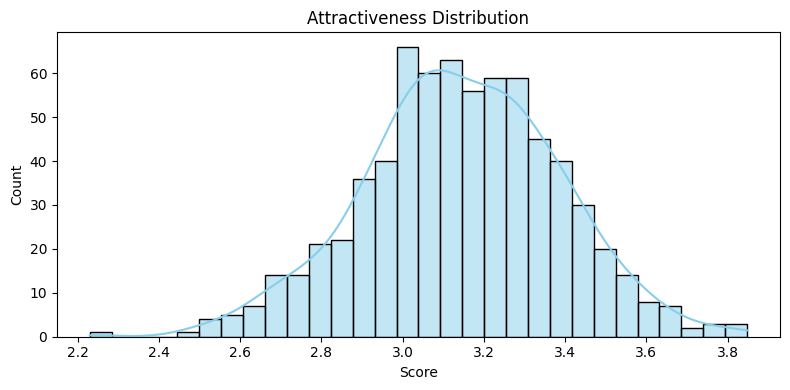

/var/folders/gz/0c41mw6j22x4rm3rkhgx2_3h0000gn/T/ipykernel_46666/2417680037.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=pdf, x="gender_final", palette="Set2")


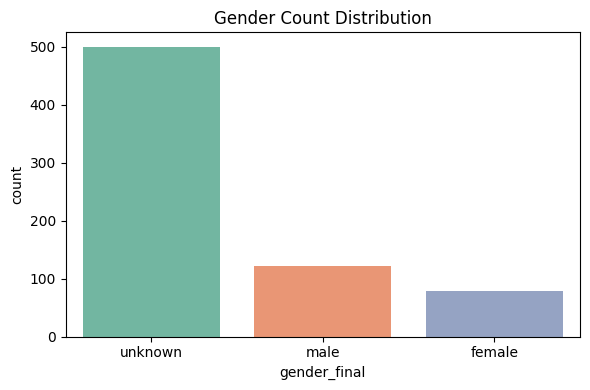

/var/folders/gz/0c41mw6j22x4rm3rkhgx2_3h0000gn/T/ipykernel_46666/2417680037.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=pdf, x="ethnicity_final", palette="Set3")


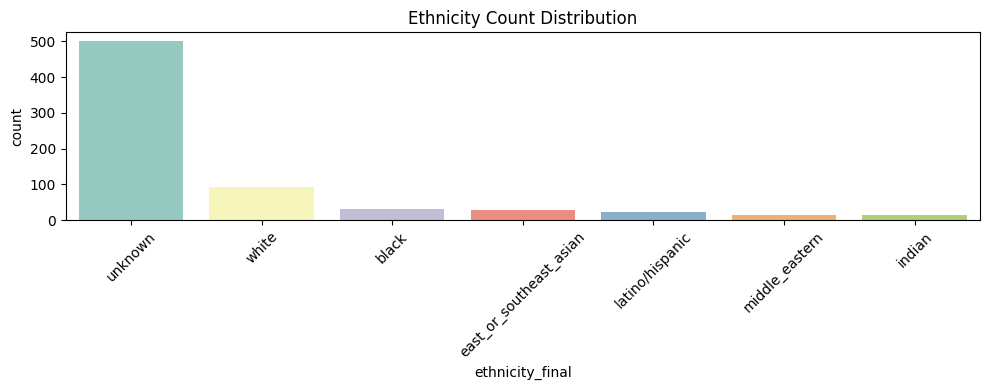


Summary complete.


In [33]:
# =============================================================
# Step 12 — Summary & Sanity Check (Mini-Report)
# =============================================================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("Building inference summary…")

pdf = df.to_pandas()

# ------------------------------
# Basic stats
# ------------------------------
print("\n=== Dataset Summary ===")
print("Total images:", len(pdf))
print("Attractiveness range:", float(pdf["attractiveness"].min()), "→", float(pdf["attractiveness"].max()))
print("Attractiveness mean:", float(pdf["attractiveness"].mean()))
print("Attractiveness std:", float(pdf["attractiveness"].std()))

# ------------------------------
# Histogram
# ------------------------------
plt.figure(figsize=(8, 4))
sns.histplot(pdf["attractiveness"], bins=30, kde=True, color="skyblue")
plt.title("Attractiveness Distribution")
plt.xlabel("Score")
plt.tight_layout()
plt.show()

# ------------------------------
# Gender counts
# ------------------------------
plt.figure(figsize=(6, 4))
sns.countplot(data=pdf, x="gender_final", palette="Set2")
plt.title("Gender Count Distribution")
plt.tight_layout()
plt.show()

# ------------------------------
# Ethnicity counts
# ------------------------------
plt.figure(figsize=(10, 4))
sns.countplot(data=pdf, x="ethnicity_final", palette="Set3")
plt.title("Ethnicity Count Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nSummary complete.")


# ✅ Conclusion — FS05 Attractiveness Inference Complete

This notebook successfully:

- Loaded CLIP embeddings  
- Loaded final metadata (age, gender_final, ethnicity_final)  
- Loaded the trained attractiveness regressor  
- Generated attractiveness predictions for all images  
- Built interactive query tools  
- Visualized nearest neighbors in embedding space  
- Saved all required inference outputs:

    - `data/processed/metadata/attractiveness_scores.parquet`  
    - `data/processed/attractiveness_scores.npy`  
    - `data/processed/metadata/feature_index.json`  

These files now serve as the **foundation for downstream steps**:

### ▶ FS06 — Composite Generation (10 deciles, filtering, PCA groups)  
### ▶ FS07 — Ethnicity Clusters  
### ▶ FS08 — Dashboard Integration (Streamlit)  

You may now proceed to the next notebook in the FaceStats V4 workflow:

**`notebooks/06_composites.ipynb`**  
(or the next approved step in your pipeline).
